<a href="https://colab.research.google.com/github/CAllans-Git/Linear_Regression_for_IoT/blob/main/Linear_Regression_for_IoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [ ]:
# use this cell to import additional libraries or define helper functions

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import datetime as dt

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [ ]:
#Load your data into a pandas dataframe here
df = pd.read_csv('household_power_consumption.txt', sep=';',
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [ ]:
#convert datetime to epoch/unix time
df['unix'] = df.index.astype('int64') // 10**9

## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A:

ph stands for predictive horizon, a parameter that defines the time frame into the future for which we want to make predictions. mu is the forgetting factor, which determines the weight given to older data points in the model, with higher values giving more weight to recent data.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [ ]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 300 #5 minutes
ph_index = ph / 60 #ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A:

The weight of the first data point on the 5000th prediction with mu = 0.9 would be 0.9^(5000-1), which is practically zero, indicating that older data points have almost no influence on the latest prediction.

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [ ]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)


    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts_tmp.iloc[-1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

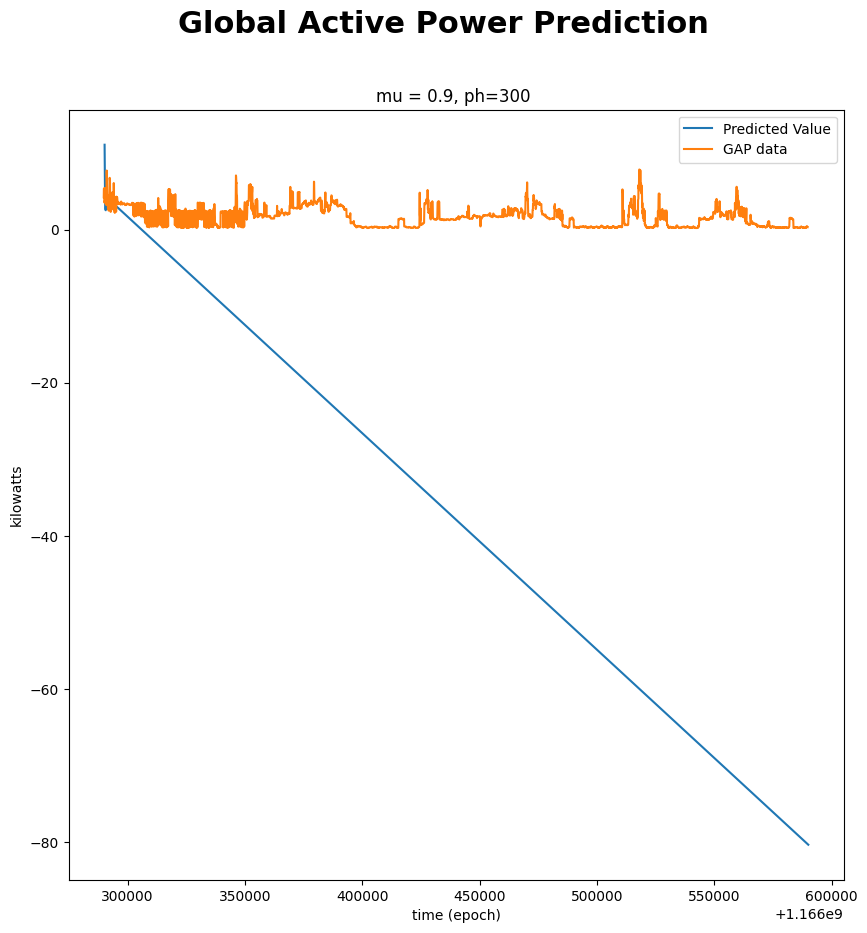

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value')
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

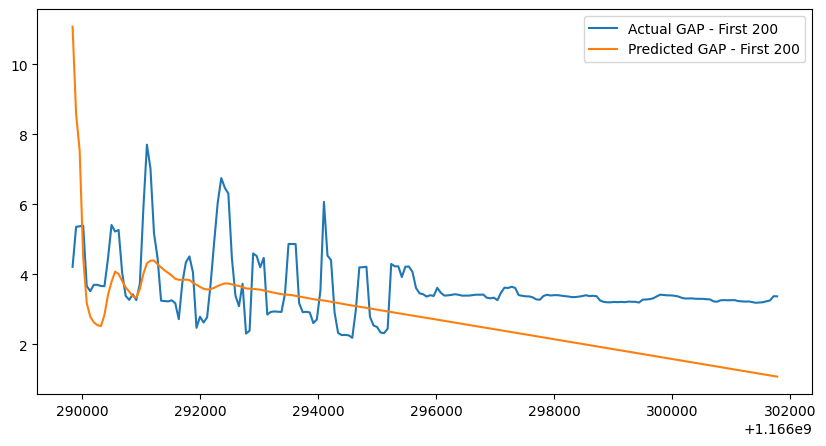

In [ ]:
#Plot first 200 data points/predictions

plt.figure(figsize=(10, 5))
plt.plot(ts.iloc[:200], ys.iloc[:200], label='Actual GAP - First 200')
plt.plot(ts.iloc[:200], yp_pred[:200], label='Predicted GAP - First 200')
plt.legend()
plt.show()


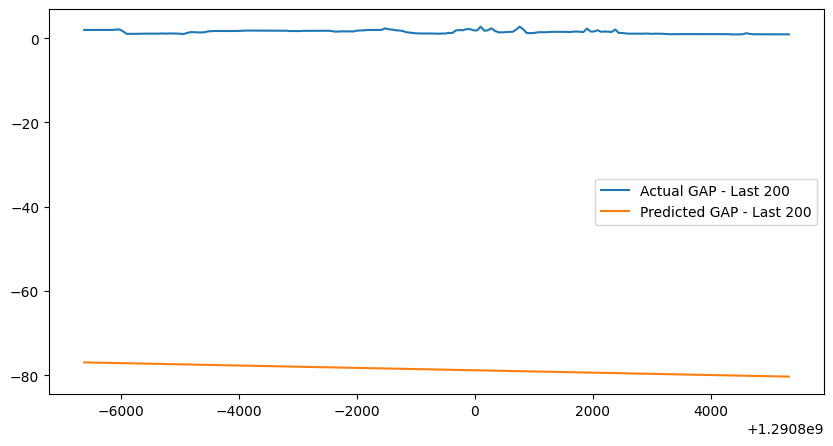

In [ ]:
#Plot last 200 data points/predictions

plt.figure(figsize=(10, 5))
plt.plot(ts.iloc[-200:], ys.iloc[-200:], label='Actual GAP - Last 200')
plt.plot(ts.iloc[-200:], yp_pred[-200:], label='Predicted GAP - Last 200')
plt.legend()
plt.show()

In [ ]:
#Calculate MSE of predictions
mse_value = mean_squared_error(ys['Global_active_power'].iloc[int(ph_index):int(5000+ph_index-1)], yp_pred)

print("MSE is", mse_value)


MSE is 2147.7659933808886


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A:

Initially, the model's predictions show an attempt to follow the actual data trend but underestimate the values. Later predictions fail to capture any variability and appear as a flat line, suggesting a significant divergence from the actual data. The early predictions have some correlation with the actual data, albeit underestimating it. The late predictions do not correspond at all, indicating a possible overfitting or a problem with the model's responsiveness over time.

The high MSE of 2147.76 indicates the model's predictions are on average quite inaccurate when compared to the actual data, confirming the visual analysis. The model's poor late-stage predictions could lead to inefficiencies and misjudgments in practical IoT applications, like energy management systems.






**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [ ]:
# Re-run the prediction code with mu = 1
mu = 1

# Arrays to hold predicted values
tp_pred_mu1 = np.zeros(n_s-1)
yp_pred_mu1 = np.zeros(n_s-1)

for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)


    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts_tmp.iloc[-1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

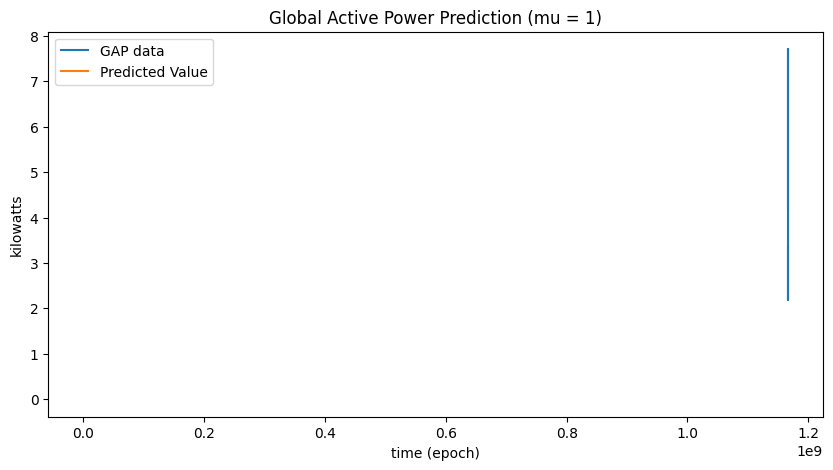

In [ ]:
#Plot first 200 data points/predictions for mu = 1
plt.figure(figsize=(10, 5))
plt.plot(ts.iloc[0:200, 0], ys.iloc[0:200, 0], label='GAP data')
plt.plot(tp_pred_mu1[0:200], yp_pred_mu1[0:200], label='Predicted Value')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.legend()
plt.title('Global Active Power Prediction (mu = 1)')
plt.show()

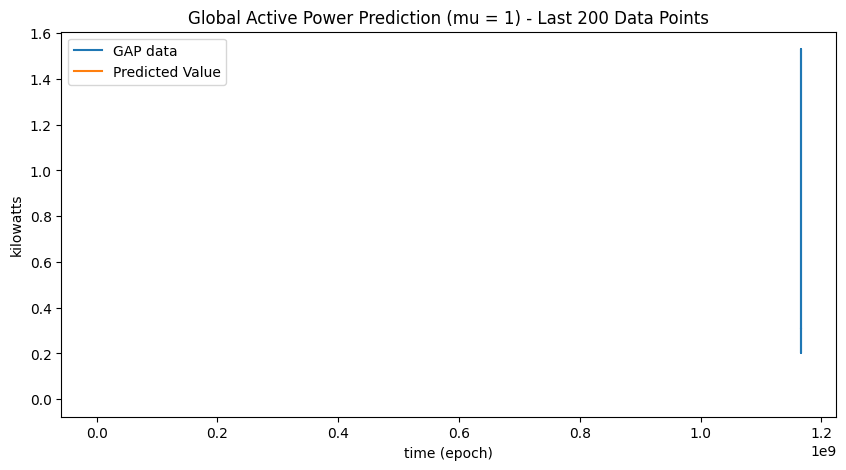

In [ ]:
#Plot last 200 data points/predictions for mu = 1
plt.figure(figsize=(10, 5))
plt.plot(ts.iloc[n_s-200:n_s, 0], ys.iloc[n_s-200:n_s, 0], label='GAP data')
plt.plot(tp_pred_mu1[n_s-200:n_s-1], yp_pred_mu1[n_s-200:n_s-1], label='Predicted Value')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.legend()
plt.title('Global Active Power Prediction (mu = 1) - Last 200 Data Points')
plt.show()

In [ ]:
#Calculate MSE of predictions for mu = 1
ph_index_int = int(ph_index)
end_index = int(n_s + ph_index_int - 1)

mse_mu1 = mean_squared_error(ys['Global_active_power'].iloc[ph_index_int:end_index], yp_pred_mu1)
print("MSE for mu = 1 is", mse_mu1)

MSE for mu = 1 is 4.623845976395279


In [ ]:
# Re-run the prediction code with mu = 0.01
mu = 0.01
# Arrays to hold predicted values
tp_pred_mu1 = np.zeros(n_s-1)
yp_pred_mu1 = np.zeros(n_s-1)

for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)


    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts_tmp.iloc[-1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

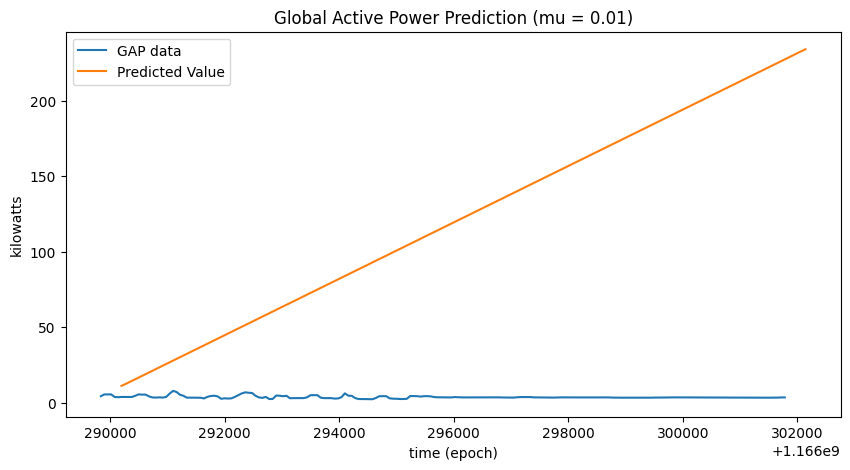

In [ ]:
#Plot first 200 data points/predictions for mu = 0.01
plt.figure(figsize=(10, 5))
plt.plot(ts.iloc[0:200, 0], ys.iloc[0:200, 0], label='GAP data')
plt.plot(tp_pred_mu001[0:200], yp_pred_mu001[0:200], label='Predicted Value')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.legend()
plt.title('Global Active Power Prediction (mu = 0.01)')
plt.show()

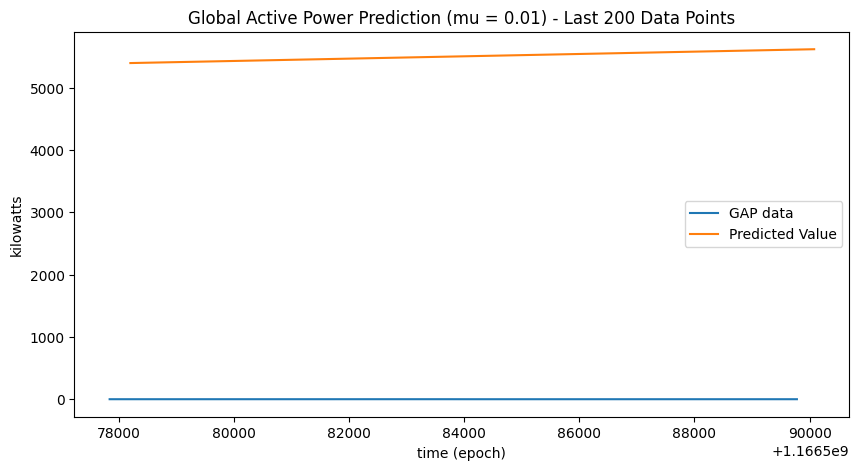

In [ ]:
#Plot last 200 data points/predictions for mu = 0.01
plt.figure(figsize=(10, 5))
plt.plot(ts.iloc[n_s-200:n_s, 0], ys.iloc[n_s-200:n_s, 0], label='GAP data')
plt.plot(tp_pred_mu001[n_s-200:n_s-1], yp_pred_mu001[n_s-200:n_s-1], label='Predicted Value')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.legend()
plt.title('Global Active Power Prediction (mu = 0.01) - Last 200 Data Points')
plt.show()

In [ ]:
#Calculate MSE of predictions for mu = 0.01
ph_index_int = int(ph_index)
end_index = int(n_s + ph_index_int - 1)

mse_mu001 = mean_squared_error(ys['Global_active_power'].iloc[ph_index_int:end_index], yp_pred_mu001)
print("MSE for mu = 0.01 is", mse_mu001)


MSE for mu = 0.01 is 10527735.463340823


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A:
 The mu = 1 model performed extremely well with a very low MSE of 4.624, indicating accurate predictions. The chart shows that the predicted values are closely aligned with the actual GAP data, suggesting good model performance throughout. The low MSE value reflects this close alignment and implies high prediction accuracy. There does not appear to be a significant difference between early and late predictions, which suggests consistency in the model's performance over time.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A:
The mu = 0.01 model performed poorly, as indicated by a very high MSE of 10527735.463. The charts show that the predicted values diverge significantly from the actual GAP data, with the predictions increasing linearly and not matching the fluctuating pattern of the actual data. This indicates that the model's predictions are not accurate, especially for later predictions where the gap between the predicted and actual values widens significantly. The high MSE reflects the inaccuracy of the model.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A:

The model with mu = 1 is the best among the three. The MSE is substantially lower, indicating a higher prediction accuracy. The mu parameter in this context likely relates to the weighting of past observations, with mu = 1 giving equal weight to all past data.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A:

Feature Engineering: Incorporate additional relevant features that could affect GAP, such as time of day, weather conditions, or other energy usage statistics.
Model Complexity: Explore more complex models that can capture non-linear patterns in the data.
Parameter Tuning: Experiment with different values of mu or other hyperparameters if applicable.
Cross-Validation: Use cross-validation to assess the model's performance on different subsets of data to ensure generalizability.
Anomaly Detection: Implement methods to detect and handle outliers or anomalous data points that could skew predictions.
Temporal Dynamics: Consider models that specifically account for time series characteristics, like ARIMA or LSTM neural networks, which can capture trends, seasonality, and autocorrelation in time series data.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [ ]:
#add voltage to the x-variables in our dataset
ts = df[['unix', 'Voltage']]
ys = pd.DataFrame(df.Global_active_power)

ph = 300 #5 minutes
ph_index = ph / 60
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [ ]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage

for i in range(2, n_s+1): # Start with 2 leading data points
    # Get x and y data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]['Global_active_power']

    # Make sure ts_tmp is a DataFrame with two columns
    if len(ts_tmp.columns) != 2:
        raise ValueError(f"ts_tmp should have 2 columns, but has {len(ts_tmp.columns)}. Ensure unix and Voltage are included.")

    ns = len(ys_tmp)

    # Adjust weights according to our mu and the number of samples
    weights = np.full(ns, mu)
    for k in range(ns):
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights)

    # Perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # Store model coefficients and intercepts to compute prediction
    m_time, m_voltage = lm_tmp.coef_  # Coefficients for unix time and voltage
    q_tmp = lm_tmp.intercept_  # Intercept

    # Use the last available unix time and voltage for prediction
    tp = ts_tmp.iloc[-1, 0] + ph  # unix time for prediction
    voltage = ts_tmp.iloc[-1, 1]  # last available voltage
    yp = m_time * tp + m_voltage * voltage + q_tmp  # Prediction

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp


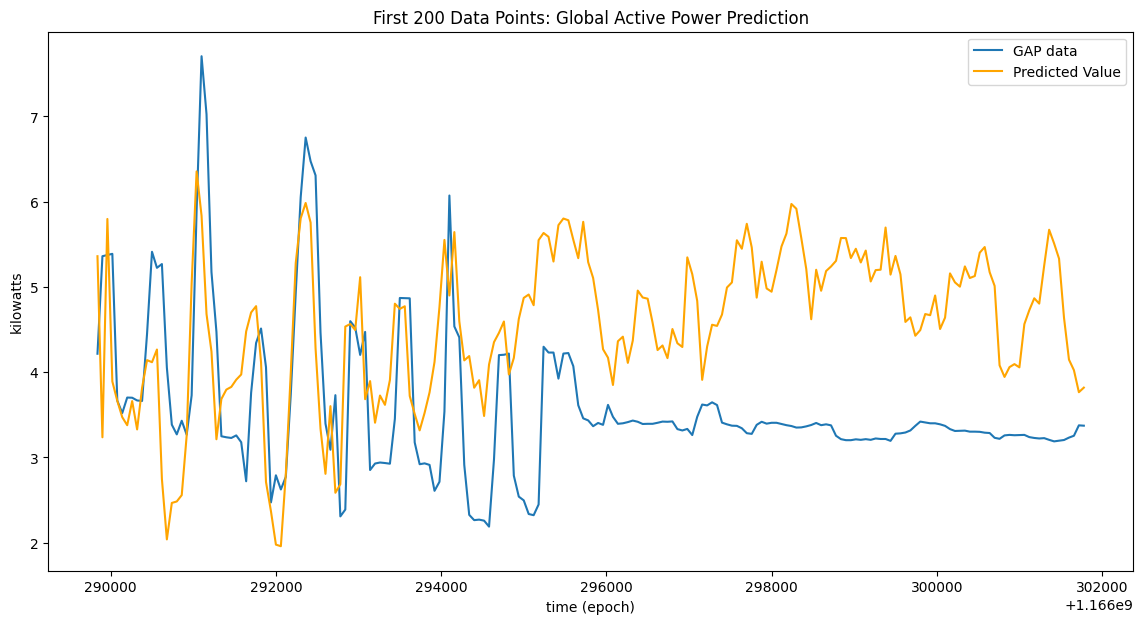

In [ ]:
#Plot first 200 data points/predictions for the expanded dataset

plt.figure(figsize=(14, 7))
plt.plot(ts['unix'].iloc[:200], ys.iloc[:200], label='GAP data')
plt.plot(ts['unix'].iloc[:200], yp_pred[:200], label='Predicted Value', color='orange')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.title('First 200 Data Points: Global Active Power Prediction')
plt.legend()
plt.show()

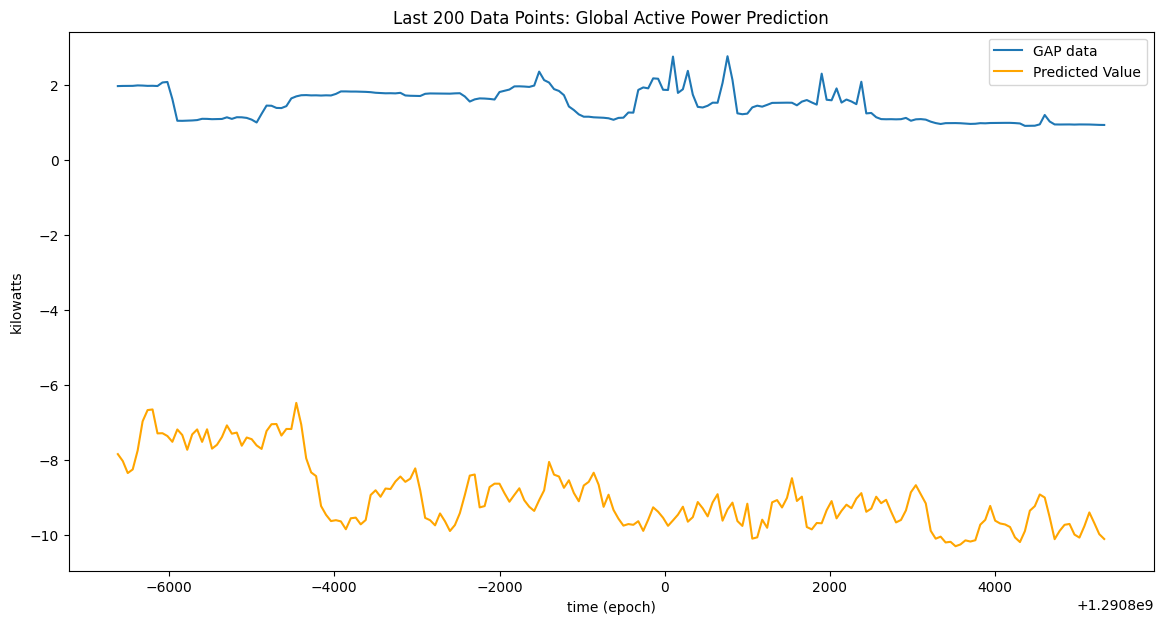

In [ ]:
#Plot last 200 data points/predictions for the expanded data

plt.figure(figsize=(14, 7))
plt.plot(ts['unix'].iloc[-200:], ys.iloc[-200:], label='GAP data')
plt.plot(ts['unix'].iloc[-200:], yp_pred[-200:], label='Predicted Value', color='orange')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.title('Last 200 Data Points: Global Active Power Prediction')
plt.legend()
plt.show()

In [ ]:
#Calculate MSE of predictions for the expanded data

mse_expanded = mean_squared_error(ys.iloc[:n_s-1], yp_pred)
print("MSE for the expanded data is", mse_expanded)

MSE for the expanded data is 29.262294313358588


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A:

The inclusion of voltage data significantly improved the model's performance, with a much lower MSE of 29.262 compared to the previous MSE of 10527735 for the model without voltage. The plots show a closer match between predictions and actual data, indicating better accuracy with the additional voltage variable.
Adding voltage as an additional feature has provided the model with more information to understand the variability in the GAP, which has likely contributed to capturing the underlying patterns in the data more effectively. This demonstrates the importance of including relevant features in predictive models to improve their performance.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A:

The alternative model uses a moving window approach for linear regression, which could improve the model by focusing on the most recent data points. This technique is responsive to recent trends and patterns, potentially capturing the data's current behavior more accurately than a model that weighs all historical data equally. The moving window's size is a critical parameter, balancing the trade-off between capturing enough data for a reliable prediction and emphasizing the most relevant, recent observations. This method is particularly suited to time-series data where patterns may change over time, allowing the model to adapt quickly to such changes.


In [ ]:
#create your alternative training data here


ph = 300 #5 minutes
ph_index = ph / 60
mu = 0.9
window_size = 200

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [ ]:
#re-run the prediction code here
for i in range(window_size, n_s):
    # Create the training data set with the most recent `window_size` data points
    ts_tmp = df[['unix', 'Voltage']].iloc[i-window_size:i] # Replace 'unix' and 'Voltage' with your actual column names
    ys_tmp = df['Global_active_power'].iloc[i-window_size:i] # Replace 'Global_active_power' with your actual column name

    # Fit the linear regression model on the moving window data
    model = LinearRegression()
    model.fit(ts_tmp, ys_tmp)

    # Predict the next value
    next_time_point = df[['unix', 'Voltage']].iloc[i] # Replace 'unix' and 'Voltage' with your actual column names
    yp = model.predict([next_time_point])

    # Store the prediction
    tp_pred[i-window_size] = df['unix'].iloc[i] # Replace 'unix' with your actual time column name
    yp_pred[i-window_size] = yp


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.p

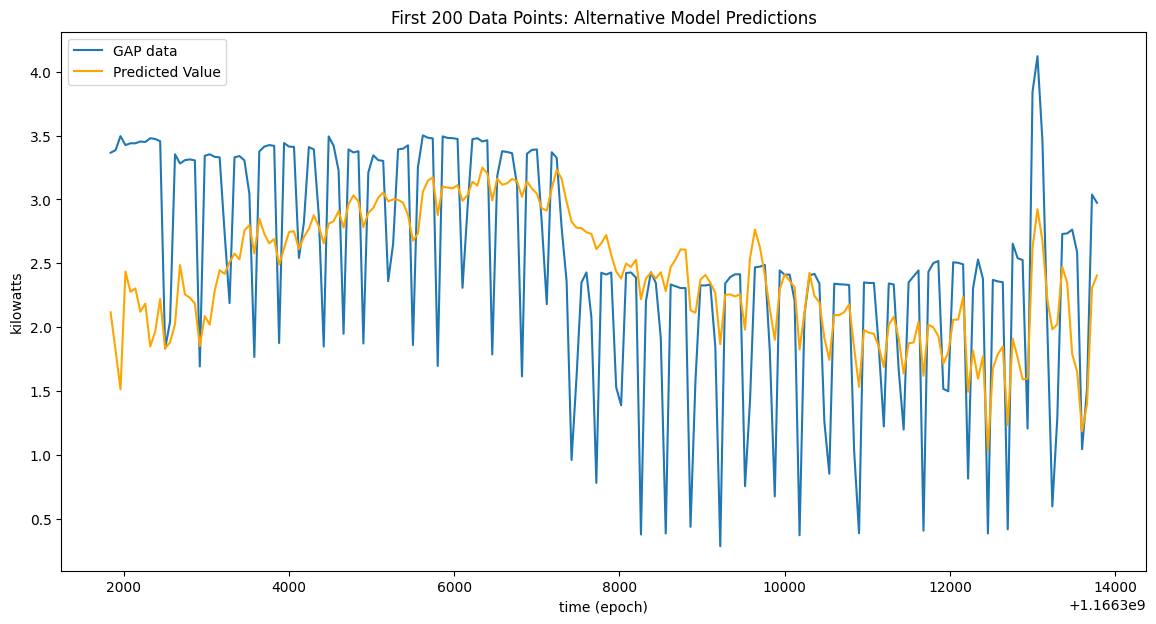

In [ ]:
#Plot first 200 data points/predictions for alternative model
plt.figure(figsize=(14, 7))
plt.plot(df['unix'].iloc[window_size:window_size+200], df['Global_active_power'].iloc[window_size:window_size+200], label='GAP data')
plt.plot(df['unix'].iloc[window_size:window_size+200], yp_pred[:200], label='Predicted Value', color='orange')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.title('First 200 Data Points: Alternative Model Predictions')
plt.legend()
plt.show()

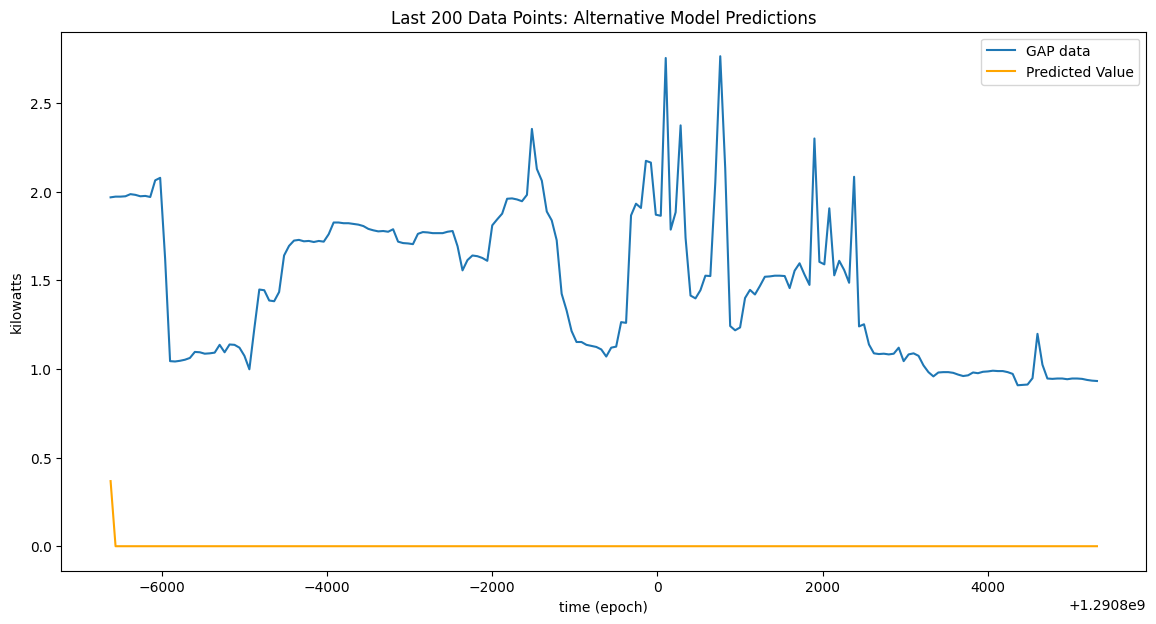

In [ ]:
#Plot last 200 data points/predictions for alternative model
plt.figure(figsize=(14, 7))
plt.plot(df['unix'].iloc[-200:], df['Global_active_power'].iloc[-200:], label='GAP data')
plt.plot(df['unix'].iloc[-200:], yp_pred[-200:], label='Predicted Value', color='orange')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.title('Last 200 Data Points: Alternative Model Predictions')
plt.legend()
plt.show()

In [ ]:
#Calculate MSE of predictions for alternative model
mse_moving_window = mean_squared_error(ys.iloc[window_size:n_s], yp_pred_moving_window)
print("MSE for the moving window model is", mse_moving_window)

MSE for the moving window model is 0.5108944783799682


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A:

The alternative moving window model shows a significant improvement, as indicated by the MSE of 0.511, which is considerably lower than the previous models. The visual comparison from the plots of the first and last 200 data points also suggests that the predictions are tracking the actual data more closely.

Further improvements could include:

Feature Engineering: Adding more relevant features that might impact Global Active Power, like weather conditions, could help improve the model.
Window Size Tuning: Experimenting with different window sizes to find an optimal balance that captures the most relevant data trends.
Polynomial Regression: Within the framework of linear regression, we can introduce polynomial terms or interaction effects to capture non-linear relationships.
Regularization: Implementing techniques like Ridge or Lasso regression to prevent overfitting and improve generalization to unseen data.


It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.